## Ant Colony Optimization algorithm  (ACOA) as an optimizer for training a NN

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization



le = LabelEncoder()
rScaler = RobustScaler()

In [19]:
# path="datasets/bin_data.csv"
# bin_data=pd.read_csv(path)
# bin_data

In [20]:
# X = bin_data.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
# Y = bin_data[['intrusion']].values # target attribute

In [21]:
# splitting the dataset 75% for training and 25% testing
# X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

In [22]:
def Fobj():
    mlp = Sequential() # creating model
    # adding input layer and first layer with 50 neurons
    # X_train.shape is (94479, 93)
    mlp.add(Dense(units=33, input_dim=X_train.shape[1], activation='relu'))#50x93=4650
    # output layer with sigmoid activation
    mlp.add(Dense(units=1,activation='sigmoid'))
    return mlp
# len(Fobj().get_weights()[1])
# Fobj().get_weights()[0].flatten().shape[0]

In [23]:
# mlp=Fobj()
# # defining loss function, optimizer, metrics and then compiling model
# mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# dim=0;
# for i in range(len(mlp.get_weights())):# 4 for 4 array 
#     dim=dim+mlp.get_weights()[i].flatten().shape[0]# 4650+50+50+1=4751
# # dim = 4751
# # print(math.sqrt(dim))
# N=20# Population size
# X=np.zeros((N,dim)) #(20, 4751)
# # print(X[:,:3])
# Fit=np.ones(N)*float('inf') #(20, 1)
# # print(Fit.reshape(N,1))
# bF=float('inf')
# bPos=[];
# # print(len(mlp.get_weights()))#4
# # len(mlp.layers)#2

In [24]:
# get wights and bias Y=XW+bias 
def setWeights(X):
    Len=0
    # X is each row data in datasets X and len is 4751
    # len(mlp.layers is 2 each contain 4 array
    for i in range(0,len(mlp.layers)):
#         get Wights first from layers
        a=mlp.layers[i].get_weights()[0].shape
        weights=X[Len:(Len+mlp.layers[i].get_weights()[0].flatten().shape[0])]
        weights=np.reshape(weights,a) 
        Len=Len+mlp.layers[i].get_weights()[0].flatten().shape[0]
#         get bias first from layers
        a=mlp.layers[i].get_weights()[1].shape
        bias=X[Len:(Len+mlp.layers[i].get_weights()[1].flatten().shape[0])]
        bias=np.reshape(bias,a)
        Len=Len+mlp.layers[i].get_weights()[1].flatten().shape[0]
        mlp.layers[i].set_weights([weights,bias])
#         print(len(mlp.get_weights()))#4
#         len(mlp.layers)#4


In [25]:
def check_boundaries(X):
    for j in range(dim):
        if X[j]>U_bounds:
            X[j]=(L_bounds+np.random.random(1)*(U_bounds-L_bounds))
        elif  X[j]<L_bounds:
            X[j]=(L_bounds+np.random.random(1)*(U_bounds-L_bounds))

In [26]:
L_bounds=0;
U_bounds=1;
def initialization():
    for i in range(N):
        for j in range(dim):
            X[i][j]=(L_bounds+np.random.rand(1)*(U_bounds-L_bounds))
        setWeights(X[i,:])
        print("------------Solution ",i,"-------------")
        score=mlp.evaluate(X_train, y_train, verbose = 1) 
        Fit[i]= score[0]#loss
        print(score[1])#accurcy


In [27]:
#get numner node visted and probility
def pick_move(distances,pheromone, visited,alpha=1,beta=1):
    all_inds = range(len(distances))
    pheromone = np.copy(pheromone)
    # print(pheromone)
    pheromone[list(visited)] = 0
    # print(pheromone[list(visited)])
    row = pheromone ** alpha * (( 1.0 / distances) ** beta)
    # h=f"""
    # {pheromone} ** {alpha} * (( 1.0 / {dist}) ** {beta})
    # """
    # print(h)
    # print(row)
    norm_row = row / row.sum()#probility
    # print(norm_row)
    move = np_choice(all_inds, 1, p=norm_row)[0]
    return move #3

In [28]:
#get path each node
def gen_path(distances,pheromone,start=0):
    path = []
    visited = set()
    visited.add(start)
    prev = start
    for i in range(len(distances) - 1):
        move = pick_move(distances[prev],pheromone[prev], visited)
        path.append((prev, move))
        prev = move
        visited.add(move)
        # print(f"move: {move} prev:{prev} visited: {visited}")
        # print(f"-- path {path}")
    path.append((prev, start)) # going back to where we started   
    # print(f"path {path}")
    return path

In [29]:
#get distance each node
def gen_path_dist(distances,path):
    total_dist = 0
    # get values shortest path after
    total_value=list()
    for ele in path:
          total_value.append(distances[ele])
          total_dist +=distances[ele]
    #     print(f"{ele} : {distances[ele]}")
    # print(f"total_dist: {total_dist}")
    return total_dist,total_value

In [30]:
#get distance each node and path in all_path
def gen_all_paths(distances,pheromone,n_ants):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(distances,pheromone)
        genPathDist,_=gen_path_dist(distances,path)
        all_paths.append((path, genPathDist))
    return all_paths

In [31]:
def spread_pheronome(distances,pheromone ,all_paths, n_best, shortest_path):
    # sorted the paths by distance
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    # print(f"sorted_paths : {sorted_paths}")
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            #update pheromone values 
            pheromone[move] += 1.0 / distances[move]
    return pheromone

In [32]:
def run(distances, n_ants, n_best, n_iterations, decay):
    all_inds = range(len(distances))
    pheromone = np.ones(distances.shape) / len(distances)
    shortest_path = None
    all_time_shortest_path = ("placeholder", np.inf)
    for i in range(n_iterations):
        #get distance each node and path in all_path
        all_paths = gen_all_paths(distances,pheromone,n_ants)
        # print(f"all_paths : {all_paths}")
        pheromone=spread_pheronome(distances,pheromone ,all_paths, n_best, shortest_path=shortest_path)
        shortest_path = min(all_paths, key=lambda x: x[1])
#         print (shortest_path)
        # swap the smallest value of shortest_path
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path            
        pheromone = pheromone * decay 
    return all_time_shortest_path

# Load the NSL_KDD dataset

In [33]:
dfTrain=pd.read_csv("KDDTrain+.csv",sep=",",encoding="utf-8")

In [34]:
dfTrain.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [35]:
dfTrain.describe()

,0,491,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,25,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,20
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,...,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,...,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,...,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [36]:
dfTrain.shape

(125972, 43)

In [41]:
#Check types for all the columns using dtypes
dfTrain.dtypes

0             int64
tcp          object
ftp_data     object
SF           object
491           int64
0.1           int64
0.2           int64
0.3           int64
0.4           int64
0.5           int64
0.6           int64
0.7           int64
0.8           int64
0.9           int64
0.10          int64
0.11          int64
0.12          int64
0.13          int64
0.14          int64
0.15          int64
0.16          int64
0.18          int64
2             int64
2.1           int64
0.00        float64
0.00.1      float64
0.00.2      float64
0.00.3      float64
1.00        float64
0.00.4      float64
0.00.5      float64
150           int64
25            int64
0.17        float64
0.03        float64
0.17.1      float64
0.00.6      float64
0.00.7      float64
0.00.8      float64
0.05        float64
0.00.9      float64
normal       object
20            int64
dtype: object

In [42]:
dfTrain.drop(dfTrain.columns[-1], axis=1, inplace=True)

In [43]:
dfTrain.info();


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 42 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   0         125972 non-null  int64  
 1   tcp       125972 non-null  object 
 2   ftp_data  125972 non-null  object 
 3   SF        125972 non-null  object 
 4   491       125972 non-null  int64  
 5   0.1       125972 non-null  int64  
 6   0.2       125972 non-null  int64  
 7   0.3       125972 non-null  int64  
 8   0.4       125972 non-null  int64  
 9   0.5       125972 non-null  int64  
 10  0.6       125972 non-null  int64  
 11  0.7       125972 non-null  int64  
 12  0.8       125972 non-null  int64  
 13  0.9       125972 non-null  int64  
 14  0.10      125972 non-null  int64  
 15  0.11      125972 non-null  int64  
 16  0.12      125972 non-null  int64  
 17  0.13      125972 non-null  int64  
 18  0.14      125972 non-null  int64  
 19  0.15      125972 non-null  int64  
 20  0.16

In [44]:
columns = (['duration'
, 'protocol_type'
, 'service'
, 'flag'
, 'src_bytes'
, 'dst_bytes'
, 'land'
, 'wrong_fragment'
, 'urgent'
, 'hot'
, 'num_failed_logins'
, 'logged_in'
, 'num_compromised'
, 'root_shell'
, 'su_attempted'
, 'num_root'
, 'num_file_creations'
, 'num_shells'
, 'num_access_files'
, 'num_outbound_cmds'
, 'is_host_login'
, 'is_guest_login'
, 'count'
, 'srv_count'
, 'serror_rate'
, 'srv_serror_rate'
, 'rerror_rate'
, 'srv_rerror_rate'
, 'same_srv_rate'
, 'diff_srv_rate'
, 'srv_diff_host_rate'
, 'dst_host_count'
, 'dst_host_srv_count'
, 'dst_host_same_srv_rate'
, 'dst_host_diff_srv_rate'
, 'dst_host_same_src_port_rate'
, 'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
, 'dst_host_srv_rerror_rate'
, 'class'])

dfTrain.columns = columns

dfTrain.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


In [45]:
dfTrain["class"].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [46]:
dfTrain['class'] = (dfTrain['class'] != "normal") * 1

dfTrain.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,1


<AxesSubplot: xlabel='protocol_type', ylabel='count'>

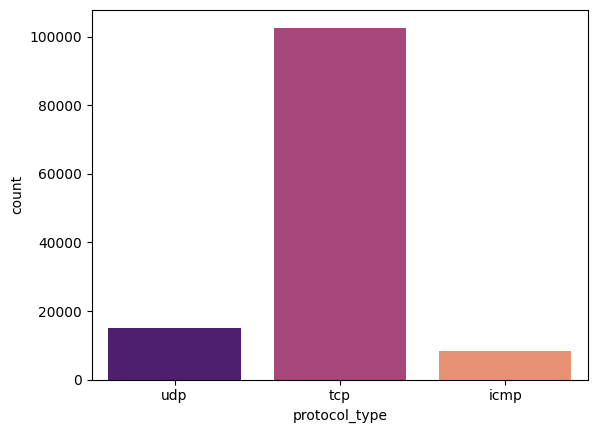

In [47]:
sns.countplot(x=dfTrain["protocol_type"],palette="magma")


<AxesSubplot: ylabel='count'>

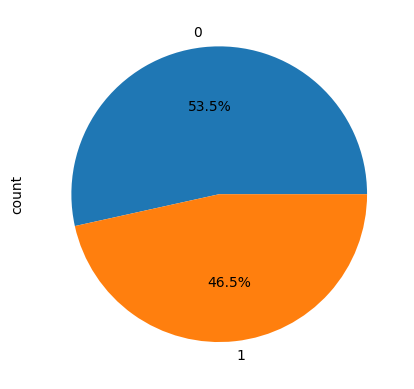

In [48]:
round(dfTrain["class"].value_counts()/dfTrain.shape[0]*100,2).plot.pie(autopct= '%1.1f%%')

<AxesSubplot: xlabel='class', ylabel='count'>

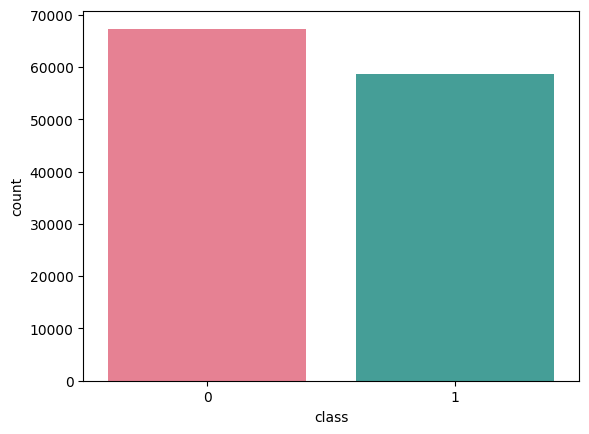

In [49]:
sns.countplot(x=dfTrain["class"],palette="husl")


In [50]:
dfTrain.isnull().sum()


duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [51]:
dfTrain.duplicated().any()


True

In [52]:
dfTrain.drop_duplicates(keep=False,inplace=True)


In [53]:
dfTrain.duplicated().any()


False

In [54]:
print(dfTrain.shape)


(125955, 42)


array([[<AxesSubplot: title={'center': 'duration'}>,
        <AxesSubplot: title={'center': 'src_bytes'}>,
        <AxesSubplot: title={'center': 'dst_bytes'}>,
        <AxesSubplot: title={'center': 'land'}>,
        <AxesSubplot: title={'center': 'wrong_fragment'}>,
        <AxesSubplot: title={'center': 'urgent'}>],
       [<AxesSubplot: title={'center': 'hot'}>,
        <AxesSubplot: title={'center': 'num_failed_logins'}>,
        <AxesSubplot: title={'center': 'logged_in'}>,
        <AxesSubplot: title={'center': 'num_compromised'}>,
        <AxesSubplot: title={'center': 'root_shell'}>,
        <AxesSubplot: title={'center': 'su_attempted'}>],
       [<AxesSubplot: title={'center': 'num_root'}>,
        <AxesSubplot: title={'center': 'num_file_creations'}>,
        <AxesSubplot: title={'center': 'num_shells'}>,
        <AxesSubplot: title={'center': 'num_access_files'}>,
        <AxesSubplot: title={'center': 'num_outbound_cmds'}>,
        <AxesSubplot: title={'center': 'is_host_

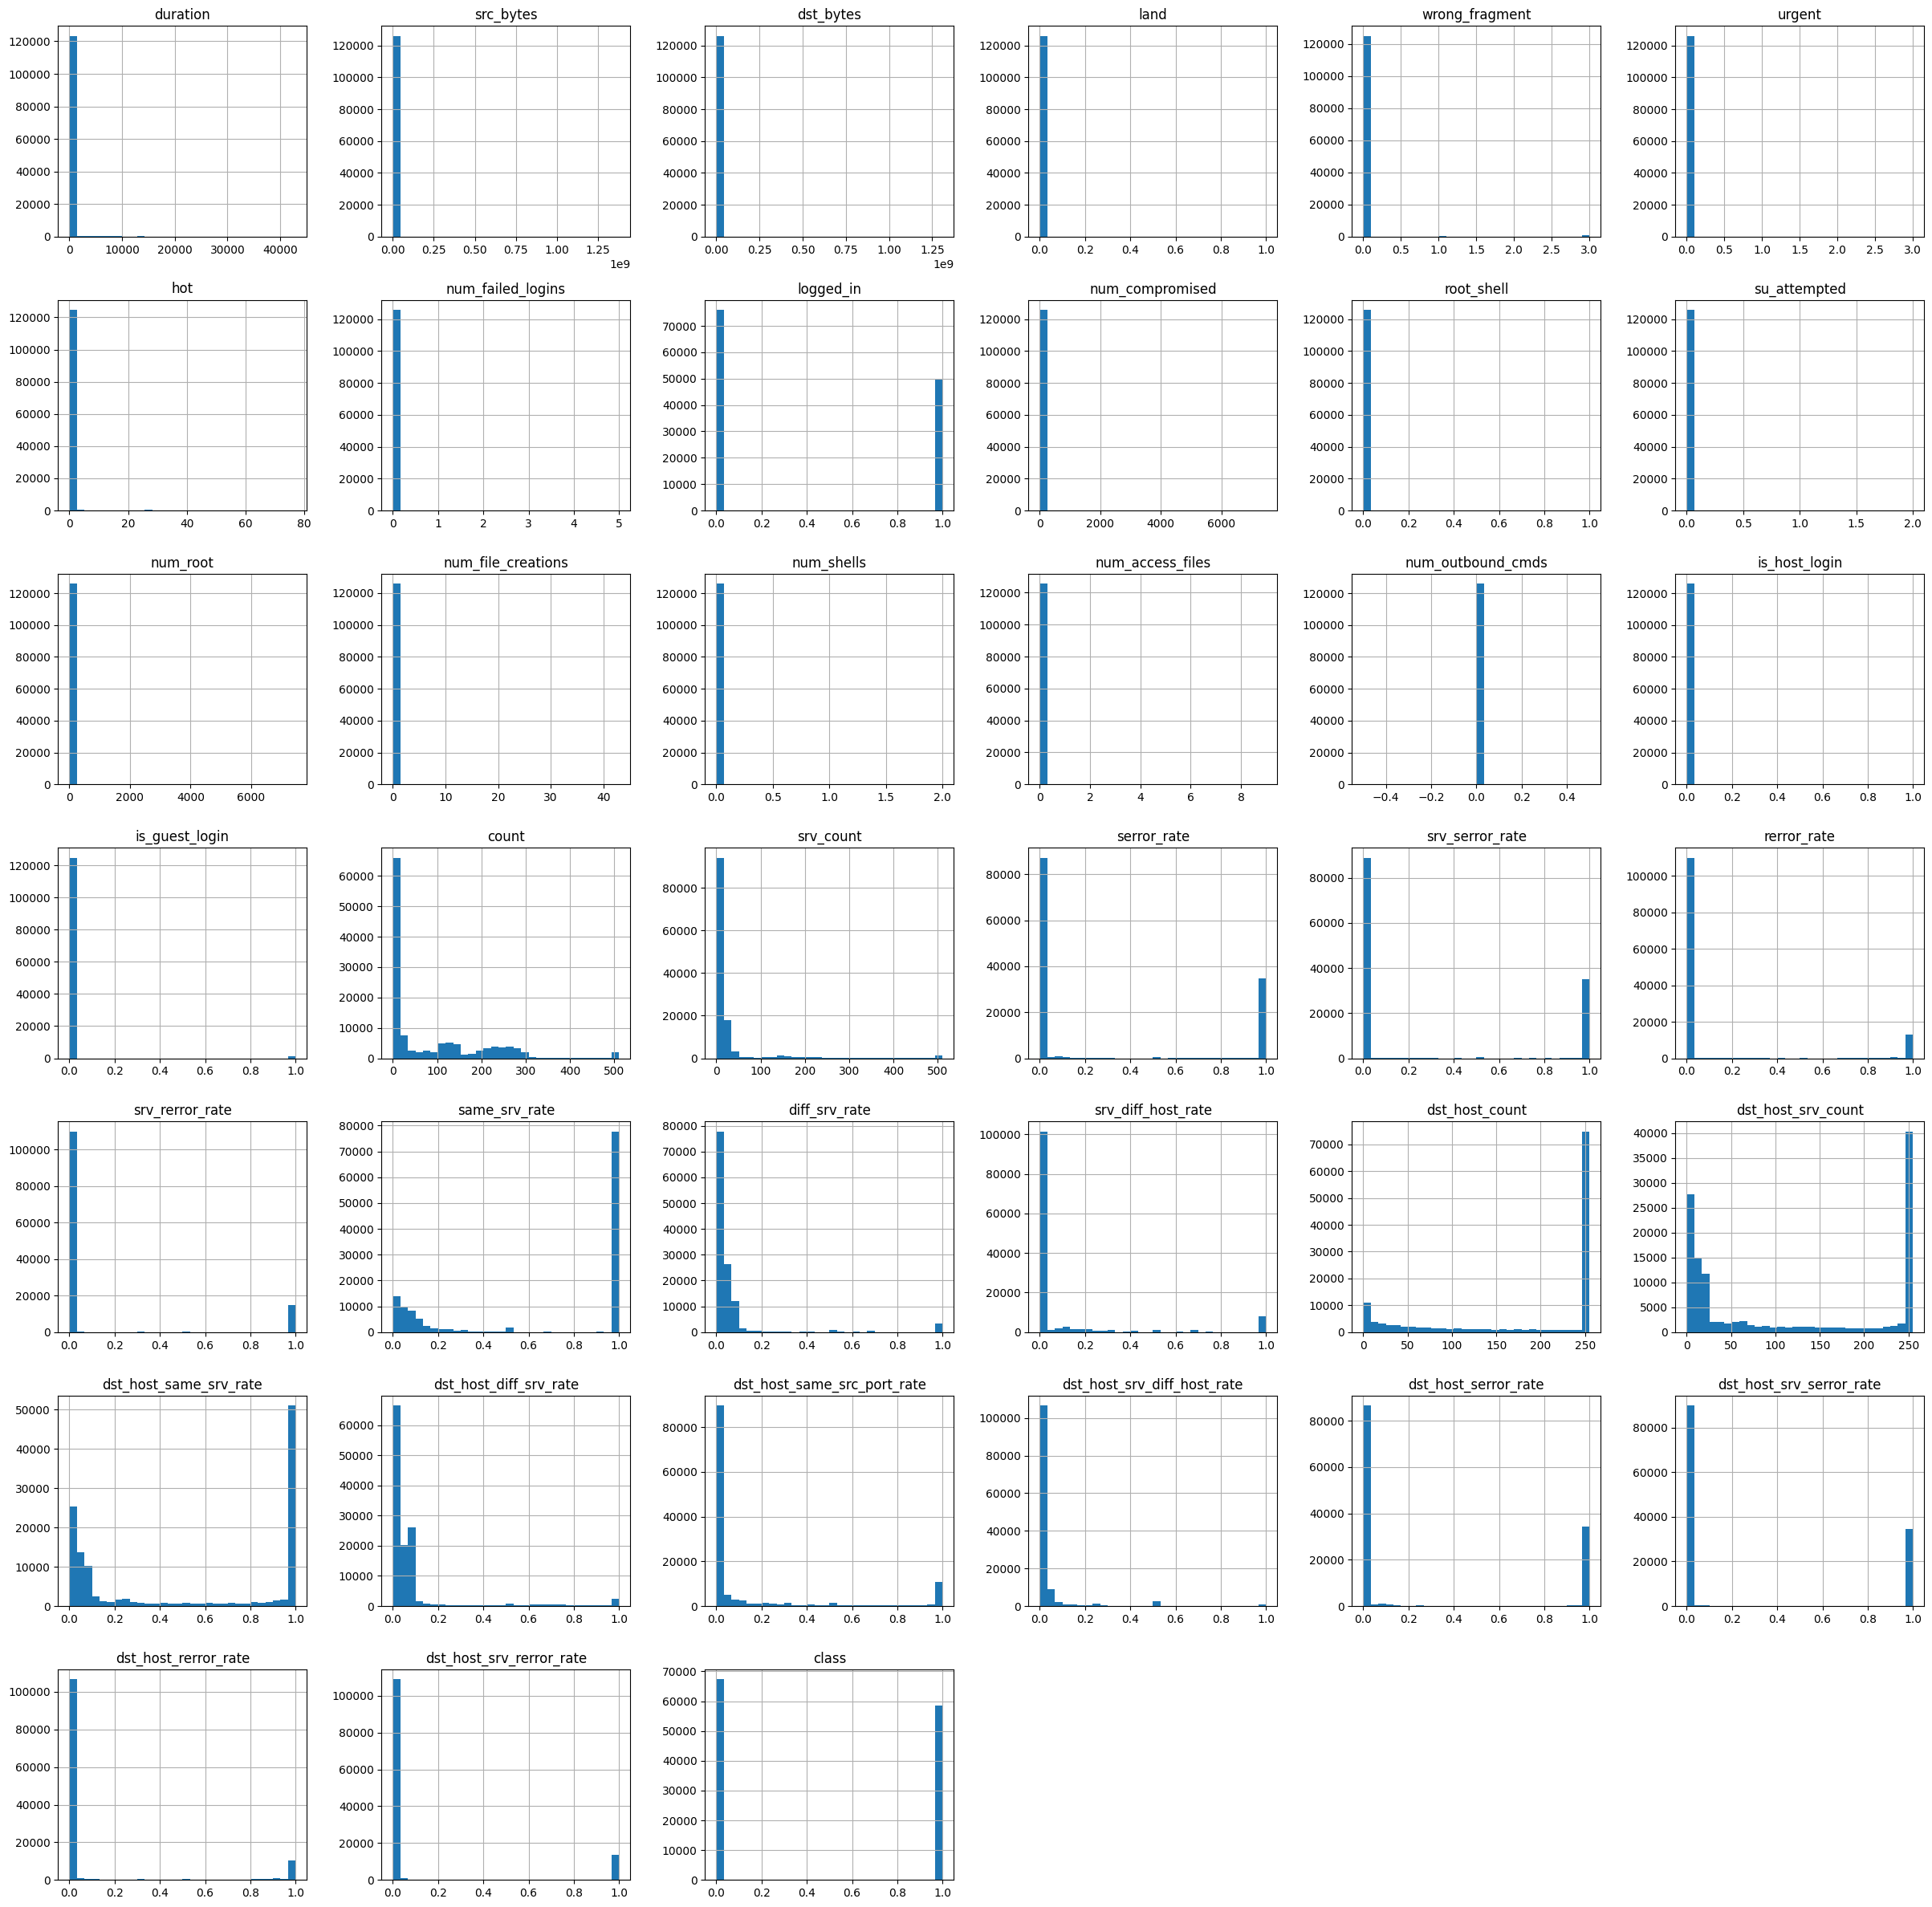

In [55]:
# drawing hist plot graphs for all columns
dfTrain.hist(bins=30,figsize=[30,30])

In [56]:
# transforming the datatype (Encoding)
dfTrain['protocol_type'] = le.fit_transform(dfTrain['protocol_type'])
dfTrain['service'] = le.fit_transform(dfTrain['service'])
dfTrain['flag'] = le.fit_transform(dfTrain['flag'])

In [57]:
# getting all possible values in column by using value_counts() function
print(dfTrain["protocol_type"].value_counts())
print(dfTrain["service"].value_counts())
print(dfTrain["flag"].value_counts())

protocol_type
1    102688
2     14993
0      8274
Name: count, dtype: int64
service
24    40338
49    21853
12     9043
54     7313
20     6859
      ...  
61        3
27        2
3         2
22        2
25        1
Name: count, Length: 70, dtype: int64
flag
9     74927
5     34851
1     11233
4      2421
2      1562
6       365
10      271
7       127
3       103
8        49
0        46
Name: count, dtype: int64


In [58]:
dfTrain.dtypes


duration                         int64
protocol_type                    int32
service                          int32
flag                             int32
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

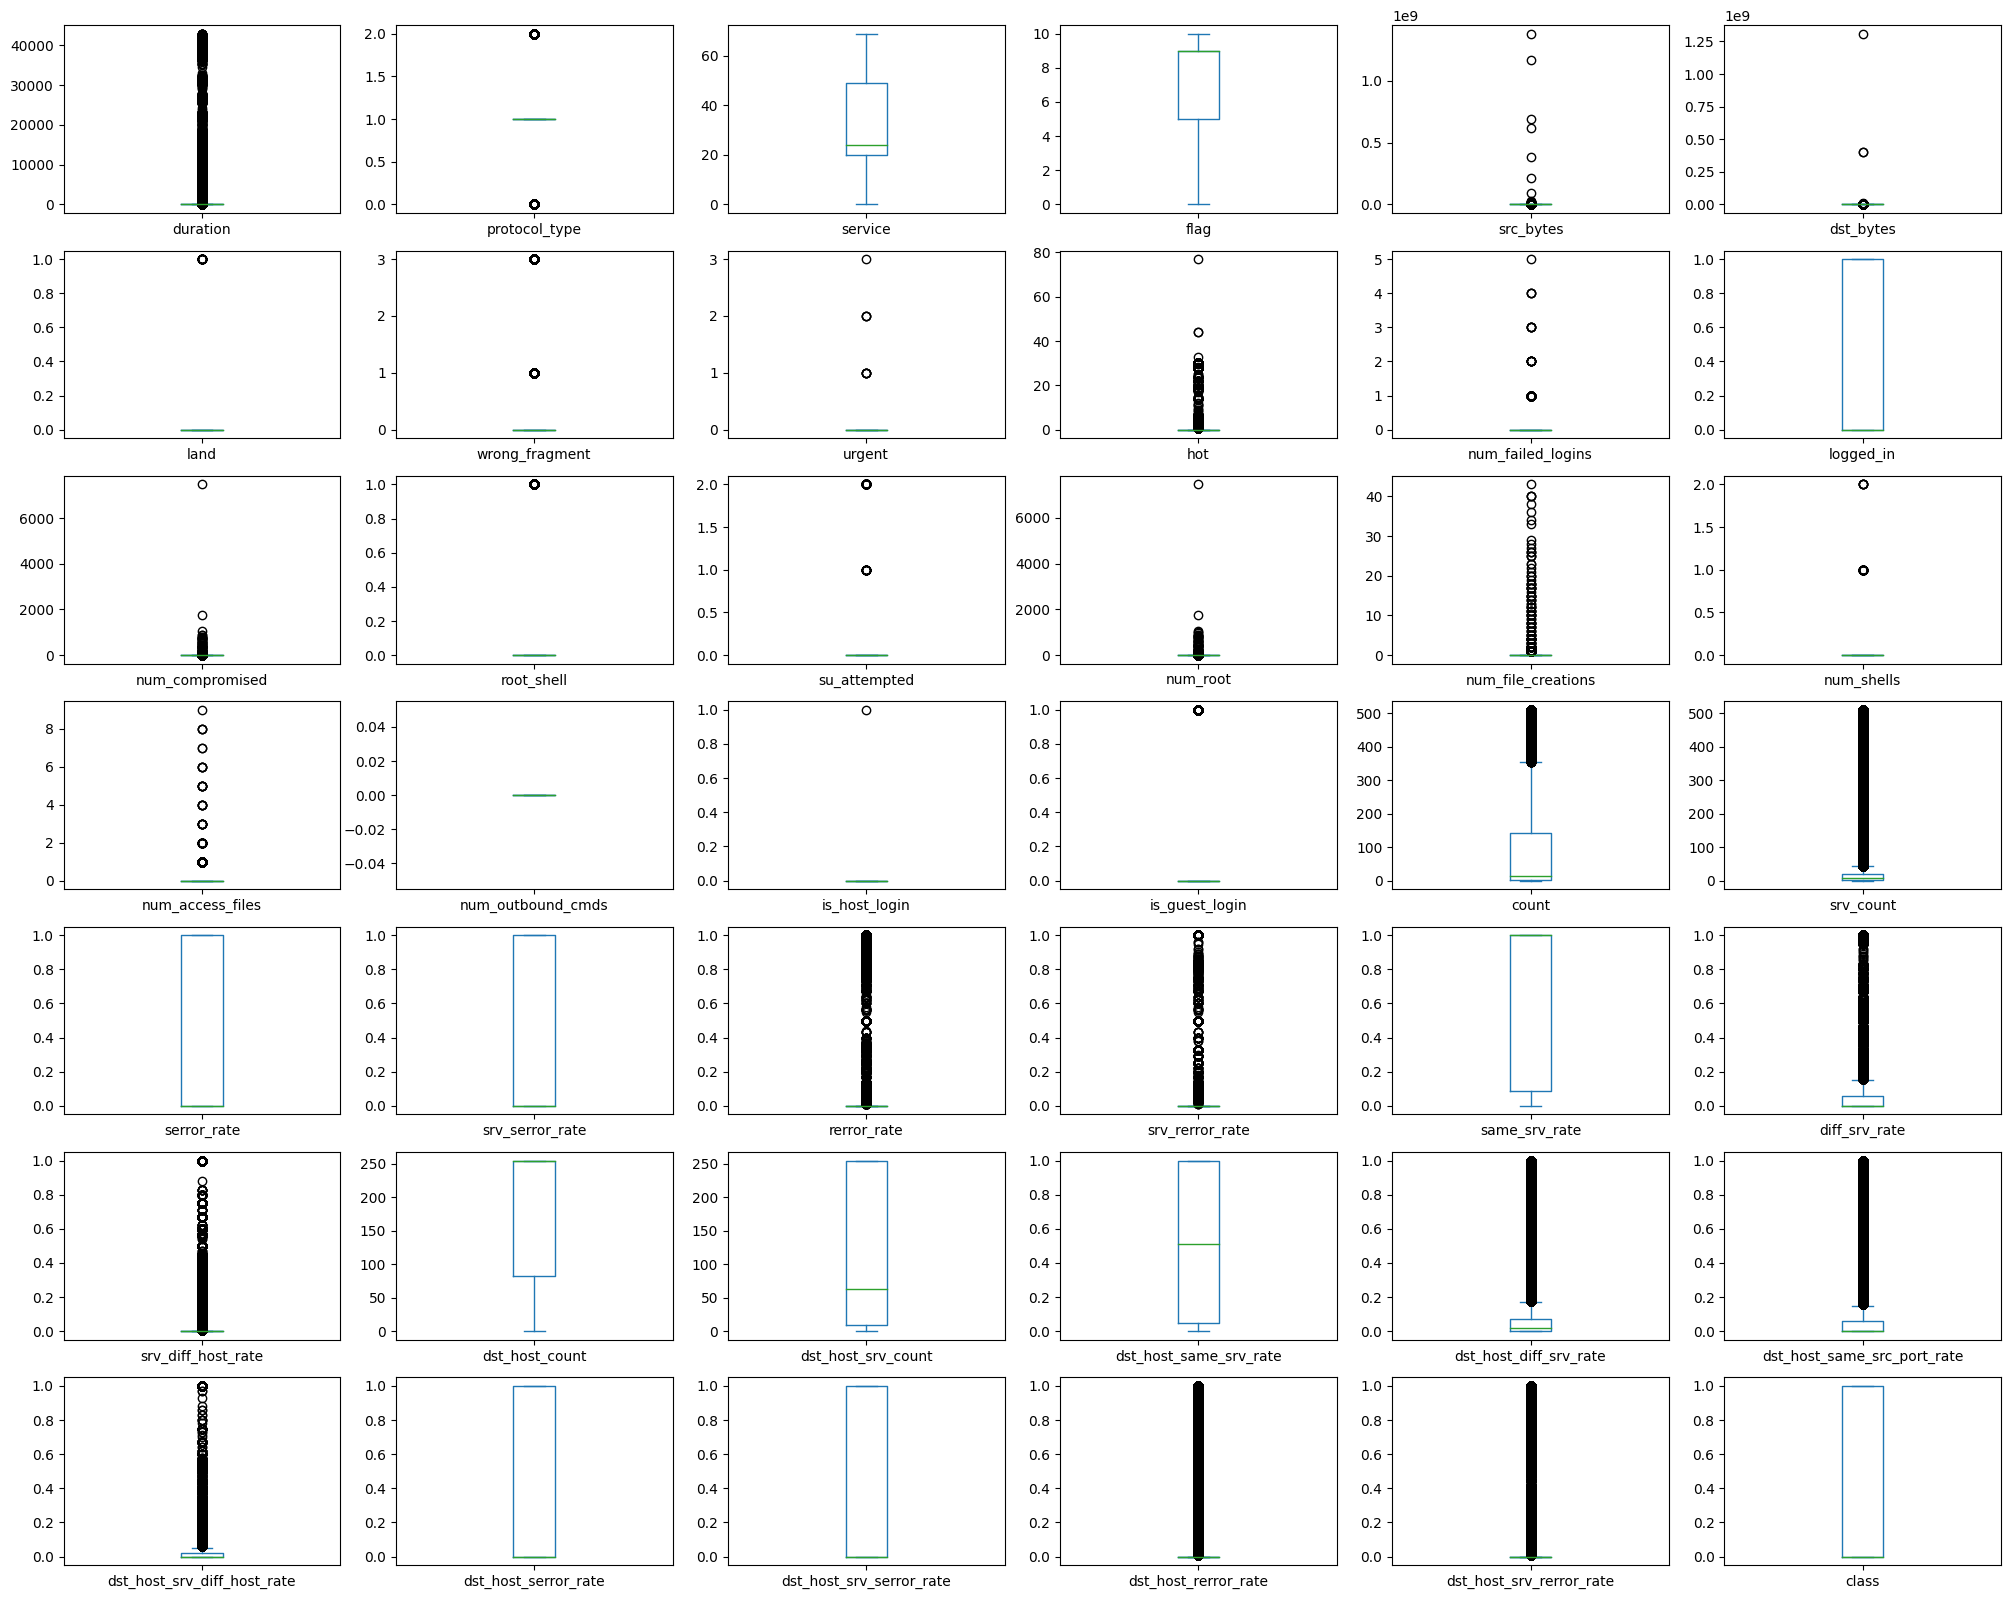

In [59]:
# drawing a box plots for all columns

dfTrain.plot(kind='box', subplots=True, layout=(7,6), figsize=(25,20))
plt.show()

In [60]:
x = dfTrain.drop(['class'], axis=1)
y = dfTrain['class'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,y , test_size=0.25, random_state=42)

In [61]:
x_train.shape


(94466, 41)

In [62]:
y_train.shape


(94466,)

In [63]:
x_test.shape


(31489, 41)

In [64]:
x_train = rScaler.fit_transform(x_train)
x_test = rScaler.fit_transform(x_test)

In [80]:
class ACO:
    def __init__(self, num_ants, num_features, alpha, beta, evaporation_rate):
        self.num_ants = num_ants
        self.num_features = num_features
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone = np.ones(num_features)  # Initialize pheromone for each feature
    
    def initialize_ants(self):
        # Initialize ant configurations (e.g., random feature selection)
        return [np.random.rand(self.num_features) for _ in range(self.num_ants)]
    
    def predict(self, ant, X):
        # Dummy predict function: Implement actual classification logic
        predictions = []
        for sample in X:
            # This is a placeholder; replace with actual logic using ant's configuration
            prediction = np.random.choice([0, 1])  # Example binary classification
            predictions.append(prediction)
        return np.array(predictions)
    
    def run(self, X_train, y_train):
        # Initialize ants (this might be the number of ants)
        ants = self.initialize_ants()

        # Predict the labels for the entire training set using each ant
        all_predictions = []  # List to hold predictions for each ant
        
        for ant in ants:
            # Make predictions for the entire training set
            predictions = self.predict(ant, X_train)
            all_predictions.append(predictions)
        
        # Convert all_predictions into a 2D array (shape: [num_ants, num_samples])
        all_predictions = np.array(all_predictions)

        # Calculate accuracy for each ant's predictions
        accuracies = [accuracy_score(y_train, pred) for pred in all_predictions]

        # Choose the best-performing ant based on accuracy
        best_ant_index = np.argmax(accuracies)
        best_ant = ants[best_ant_index]
        
        return best_ant


In [81]:
def predict(self, ant, X):
    # Example: Predict for the entire dataset X based on the ant's configuration
    # Ensure predictions are made for every sample in X
    predictions = []
    for sample in X:
        prediction = self.classify_sample(ant, sample)  # Replace with your logic
        predictions.append(prediction)
    
    return np.array(predictions)  # Return as a numpy array for consistency


In [83]:
# Make sure to import the necessary libraries
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize the ACO algorithm
aco = ACO(100, x_train.shape[1], 1, 1, 0.1)

# Run the ACO algorithm
ant = aco.run(x_train, y_train)

# Predict the labels of the test set
predictions = np.array([aco.predict(ant, X) for X in x_test])

# Evaluate the accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets